In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
## basic functionality
import rasterio 

import re
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import joblib
from joblib import Parallel, delayed
import plotnine
from plotnine import *
#import geopandas as gpd
## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime
import time
import geopandas as gpd
## useful material for fuzz match 
#https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings

import rasterstats

import xgboost

C:\ProgramData\Anaconda3\envs\g_env\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.


## Load shapefile

First we load the polygon shapefile (in ESRI .shp) format for GPs in Odisha.

In [3]:
od_gp = gpd.read_file(r'C:\Users\HK\Dropbox\Research@ASPIRE\GPDP\STATAWork\RawData\AdminData\Shapefiles\odisha_GP.shp')

## Load raster

Next, we read in the satellite image/raster of nightlight intensity, in .tiff format. Currently the image file depicts the entire world.


#### DMSP- VIIRS harmonized (Elvidge et al, 2018)

https://www.mdpi.com/2072-4292/13/5/922



#### VIIRS data (version 2, more accurate/updated)

https://eogdata.mines.edu/products/vnl/

In [6]:
## Rasterio open
nightlight_file = rasterio.open(r'D:\Work\DATA\viirs 20 yr_30 arc\Harmonized_DN_NTL_2011_calDMSP.tif')

## Rasterio read
nightlights = nightlight_file.read(1)



### Check Coordinate Reference Systems (CRS)

The vector shapefile and the raster must have a common CRS to be overlaid accurately.

Here, they both share the same 'EPSG:4326' CRS.



In [5]:
nightlight_file.crs
od_gp.crs

CRS.from_epsg(4326)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Subsetting rasters with windows

We need to subset the raster to only our area of interest (AOI), Odisha. It is easiest to do it while the initial raster file is being read, by defining a **Window Object**.

Feed in the Odisha polygons shapefile to serve as a **bounding box**, or extent of the window. This will only keep the parts of the raster within the shape.

In [7]:
## Get boundaries from polygon shapefile

od_bbox = od_gp.total_bounds

# window object provided by bounding box

od_window = nightlight_file.window(*od_bbox)

od_nightlights = nightlight_file.read(1, window=od_window)

<AxesSubplot:>

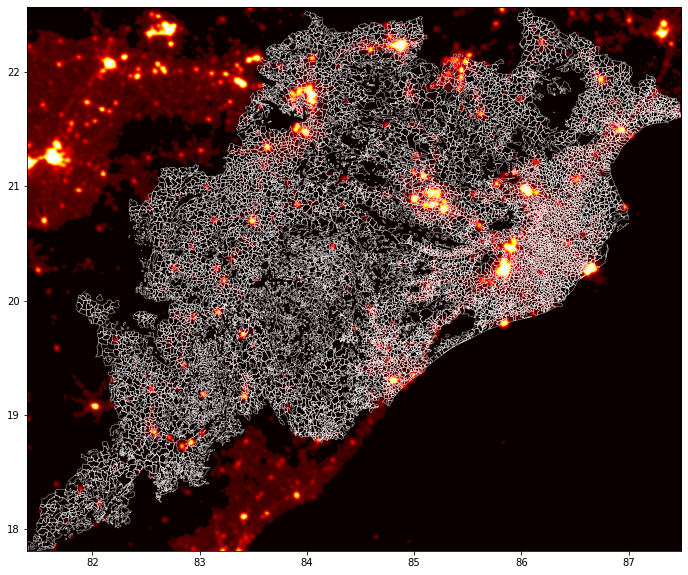

In [8]:
fig, ax = plt.subplots(figsize=(13,10))

plt.imshow(od_nightlights, extent=od_bbox[[0,2,1,3]], cmap='hot')

od_gp.boundary.plot(ax=plt.gca(),  alpha=.7, edgecolor='white', linewidth=0.5)




## Calculate raster statistics for polygons


We need to extract the information on nightlights - stored as pixel brightness - from the raster to each polygon in the vector layer. Each polygon will have multiple pixels within it, and they need to be aggregated. 

Before that, however, we need to use the rasterio 'mask' function to assign pixels to polygons. It requires an **affine transformation**.

Then, calculate the mean pixel intensity within each GP.

In [4]:
from rasterio.mask import mask

def clean_mask(geom, **mask_kw):
    mask_kw.setdefault('crop', True)
    mask_kw.setdefault('all_touched', True)
    mask_kw.setdefault('filled', False)
    masked, mask_transform = mask(dataset, shapes=(geom,),
                                  **mask_kw)
    return masked


### Loop through rasters from 2011-2018


Now, sequentially open the raster file for each year from 2011-2018, calculate the mean pixel intensity within each GP, and assign the value to a new variable named as ntl_2011, ntl_2012 and so on.

In [12]:
for i in range(2011,2019):
    if i <= 2013:
        nightlight_file = rasterio.open(r'D:\Work\DATA\viirs 20 yr_30 arc\2011_20\Harmonized_DN_NTL_'+str(i)+'_calDMSP.tif')
    else:
        nightlight_file = rasterio.open(r'D:\Work\DATA\viirs 20 yr_30 arc\2011_20\Harmonized_DN_NTL_'+str(i)+'_simVIIRS.tif')
    dataset = nightlight_file 
    varname = 'ntl_' + str(i)
    od_gp[varname] = od_gp.geometry.apply(clean_mask).apply(np.ma.mean)



In [15]:
# Export

od_gp.to_file(filename=r'C:\Users\HK\Dropbox\ppol564_group11\od_gp_ntl_2011_2018.shp.zip')

C:\ProgramData\Anaconda3\envs\g_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
C:\Users\HK\AppData\Local\Temp\ipykernel_20264\4006240140.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
